In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

class AnomalyExplanationUsingSHAP:
    '''
    This class implements the method described in 'Explaining Anomalies Detected by Autoencoders Using SHAP' to explain
    anomalies revealed by an unsupervised Autoencoder model using SHAP.
    '''
    
    model_autoencoder = None
    num_anomalies_to_explain = None
    reconstruction_error_percentage = None
    shap_values_selection_method = None
    counter = None

    def __init__(self, num_anomalies=100, reconstruction_error_percent=0.5, shap_selection='mean'):
        self.num_anomalies_to_explain = num_anomalies
        self.reconstruction_error_percentage = reconstruction_error_percent
        self.shap_values_selection_method = shap_selection

    def train_autoencoder(self, train_data, epochs=5, batch_size=64):
        input_dim = train_data.shape[1]
        print('Training data features:', input_dim)

        input_layer = Input(shape=(input_dim,))
        encoder = Dense(10, activation="relu", activity_regularizer=regularizers.l1(10e-7))(input_layer)
        encoder = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(10e-7))(encoder)
        decoder = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)
        decoder = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(10e-7))(decoder)
        decoder = Dense(input_dim, activation=None, kernel_regularizer=regularizers.l2(10e-7))(decoder)

        self.model_autoencoder = Model(inputs=input_layer, outputs=decoder)
        self.model_autoencoder.summary()

        self.model_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
        self.model_autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True,
                                   validation_split=0.1, verbose=2, callbacks=[early_stopper])
        self.model_autoencoder.save("autoencoder.h5")

        return self.model_autoencoder
                
    def get_top_anomalies_to_explain(self, explain_data):
        predictions = self.model_autoencoder.predict(explain_data)
        squared_errors = np.power(explain_data - predictions, 2)
        mse_series = pd.Series(np.mean(squared_errors, axis=1))

        most_anomalous_transactions = mse_series.sort_values(ascending=False)
        columns = ["id", "mse_all_columns"]
        columns.extend(["squared_error_" + col for col in list(explain_data.columns)])
        items = []
        for x in most_anomalous_transactions.iteritems():
            item = [x[0], x[1]]
            item.extend(squared_errors.loc[x[0]])
            items.append(item)

        anomalies_df = pd.DataFrame(items, columns=columns)
        anomalies_df.set_index('id', inplace=True)

        top_anomalies_to_explain = anomalies_df.head(self.num_anomalies_to_explain).index
        return top_anomalies_to_explain

    def get_num_features_with_high_reconstruction_error(self, total_squared_error, errors_df):
        error_sum = 0
        num_features = 0
        for index in errors_df.index:
            error_sum += errors_df.loc[index, 'err']
            if error_sum >= self.reconstruction_error_percentage * total_squared_error:
                break
            num_features += 1
        return num_features

    def get_background_set(self, train_data, background_size=200):
        background_set = train_data.head(background_size)
        return background_set

    def get_error_df_per_record(self, record):
        prediction = self.model_autoencoder.predict(np.array([[record]])[0])[0]
        squared_errors = np.power(record - prediction, 2)
        errors_df = pd.DataFrame({'col_name': squared_errors.index, 'err': squared_errors}).reset_index(drop=True)
        total_mse = np.mean(squared_errors)
        errors_df.sort_values(by='err', ascending=False, inplace=True)
        return errors_df, total_mse

    def get_high_shap_values(self, shap_values_df):
        high_contributing_features_df = pd.DataFrame()

        for i in range(shap_values_df.shape[0]):
            shap_values = shap_values_df.iloc[i]
            if self.shap_values_selection_method == 'mean':
                threshold_value = np.mean(shap_values)
            elif self.shap_values_selection_method == 'median':
                threshold_value = np.median(shap_values)
            elif self.shap_values_selection_method == 'constant':
                num_explaining_features = 5
                explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
                high_contributing_features_df = pd.concat([high_contributing_features_df, explaining_features], axis=0)
                continue
            else:
                raise ValueError('Unknown SHAP value selection method')

            num_contributing_features = 0
            for j in range(len(shap_values)):
                if shap_values[j] > threshold_value:
                    num_contributing_features += 1
            contributing_features = shap_values_df[i:i + 1].stack().nlargest(num_contributing_features)
            high_contributing_features_df = pd.concat([high_contributing_features_df, contributing_features], axis=0)
        return high_contributing_features_df

    def predict_feature(self, record):
        record_prediction = self.model_autoencoder.predict(record)[:, self.counter]
        return record_prediction

    def explain_unsupervised_data(self, train_data, explain_data, autoencoder=None, return_shap_values=False):
        self.model_autoencoder = autoencoder
        if self.model_autoencoder is None:
            self.train_autoencoder(train_data)

        top_anomalies_to_explain = self.get_top_anomalies_to_explain(explain_data)
        all_feature_sets_explanation = {}

        for record_idx in top_anomalies_to_explain:
            record_to_explain = explain_data.loc[record_idx]
            error_df, total_mse = self.get_error_df_per_record(record_to_explain)
            num_of_features = self.get_num_features_with_high_reconstruction_error(total_mse * error_df.shape[0], error_df)

            top_error_df = error_df.head(num_of_features)
            all_feature_sets_explanation[record_idx] = []
            shap_values_all_features = [[] for num in range(num_of_features)]

            background_set = self.get_background_set(train_data, 200).values
            for i in range(num_of_features):
                self.counter = top_error_df.index[i]
                explainer = shap.KernelExplainer(self.predict_feature, background_set)
                shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
                shap_values_all_features[i] = shap_values

            shap_values_all_features = np.fabs(shap_values_all_features)
            shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=train_data.columns)
            highest_contributing_features = self.get_high_shap_values(shap_values_all_features)

            for idx_explained_feature in range(num_of_features):
                feature_set = []
                for idx, row in highest_contributing_features.iterrows():
                    if idx[0] == idx_explained_feature:
                        feature_set.append((idx[1], row[0]))
                explained_feature_index = top_error_df.index[idx_explained_feature]
                feature_set.insert(0, (train_data.columns[explained_feature_index], -1))

                all_feature_sets_explanation[record_idx].append(feature_set)

            final_feature_set = []
            final_feature_items = []
            for item in sum(all_feature_sets_explanation[record_idx], []):
                if item[0] not in final_feature_set:
                    final_feature_set.append(item[0])
                    final_feature_items.append(item)

            if return_shap_values:
                all_feature_sets_explanation[record_idx] = final_feature_items
            else:
                all_feature_sets_explanation[record_idx] = final_feature_set

        return all_feature_sets_explanation


In [89]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [90]:
benign = pd.read_csv(r"C:/Users\sampa\Desktop\dataset\REGULAR.csv")
Attack = pd.read_csv(r"C:/Users\sampa\Desktop\dataset\IOT\Hulk-Evasive.csv")


# selected columns (Add more columns)
# cols is the column list for benign dataset
cols = ['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s','FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts','Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max','Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance','RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes']

# catt_cols is the column list for attack dataset (including Label column)
att_cols = ['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s','FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts','Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max','Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance','RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes','Label']

#%%
# filter columns
benign = benign[cols]
# remove inf values
benign = benign.replace([np.inf], np.nan)
benign.dropna(inplace=True)

# filter columns
Attack = Attack[att_cols]
# remove inf values
Attack = Attack.replace([np.inf], np.nan)
Attack.dropna(inplace=True)

#%%
# data normalization (this will convert all columns to 0-1 range)
scaler = MinMaxScaler()
fit_scaling = scaler.fit(benign)
fit_apply = fit_scaling.transform(benign)  # fit the scaler for benign dataset
benign_norm = pd.DataFrame(fit_apply, columns=benign.columns, index=benign.index)

Attack_label = Attack[['Label']]
Attack_X = Attack.drop('Label', axis=1)
fit_apply = fit_scaling.transform(Attack_X)  # apply normalization to attack dataset
attack_norm = pd.DataFrame(fit_apply, columns=Attack_X.columns, index=Attack_X.index)



# data preparation for autoencoder model
X_train = benign_norm   # convert pandas dataframe into a array
X_test = attack_norm


In [91]:
X_train.head()

,Flow Packets/s,Fwd PSH Flags,Fwd Packets/s,Bwd Packets/s,FIN Flag Count,PSH Flag Count,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Fwd Act Data Pkts,...,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Subflow Bwd Bytes
0,0.000340,0.000000,0.000681,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000082,0.000000,0.000164,0.00000,0.0,0.000000,0.018674,0.027211,0.004687,0.215947,...,0.041436,0.125636,0.000000,0.000000,0.0,0.125636,0.457317,0.000000,0.457317,0.000000
2,0.000015,0.000000,0.000030,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000879,0.128205,0.001147,0.00059,0.0,0.042272,0.000000,0.000000,0.000000,0.046512,...,0.019890,0.018598,0.010679,0.000114,0.0,0.018598,0.045732,0.012796,0.028963,0.010059
4,0.000319,0.923077,0.000316,0.00031,0.0,0.145310,0.000000,0.000000,0.000000,0.355482,...,0.019890,0.013767,0.010207,0.000104,0.0,0.013767,0.098448,0.000208,0.048780,0.000000


In [92]:
X_test.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [93]:
X_train.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [94]:
X_test.shape

(757027, 26)

In [95]:
Attack.Label.value_counts()

Hulk-Evasive    756987
BENIGN              40
Name: Label, dtype: int64

In [96]:
exp_model = AnomalyExplanationUsingSHAP(num_anomalies=2)


In [97]:
all_feature_sets_explanation = exp_model.explain_unsupervised_data(train_data=X_train, 
                                                                   explain_data=X_test,
                                                                   return_shap_values=True)


Training data features: 26
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_10 (Dense)            (None, 10)                270       
                                                                 
 dense_11 (Dense)            (None, 32)                352       
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
 dense_13 (Dense)            (None, 32)                352       
                                                                 
 dense_14 (Dense)            (None, 26)                858       
                                                                 
Total params: 2,162
Trainable pa

In [80]:
all_feature_sets_explanation

{602902: [('RST Flag Count', -1),
  ('Flow Packets/s', 0.3268074587450256),
  ('Fwd Packets/s', 0.21972959975321688),
  ('Bwd Packets/s', 0.1794535285190128)],
 718029: [('RST Flag Count', -1),
  ('Flow Packets/s', 0.31192656127256624),
  ('Fwd Packets/s', 0.21185545594829075),
  ('Bwd Packets/s', 0.17078843361276702),
  ('Bwd Packet Length Mean', 0.03851290064131324)]}

In [81]:
op = dict(all_feature_sets_explanation[602902])

In [83]:
type (op)

dict

In [84]:
def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

In [85]:
D = Convert(all_feature_sets_explanation[602902])

In [86]:
D=op

([<matplotlib.axis.XTick at 0x1d3a1a87550>,
 [Text(0, 0, 'RST Flag Count'),
  Text(1, 0, 'Flow Packets/s'),
  Text(2, 0, 'Fwd Packets/s'),
  Text(3, 0, 'Bwd Packets/s')])

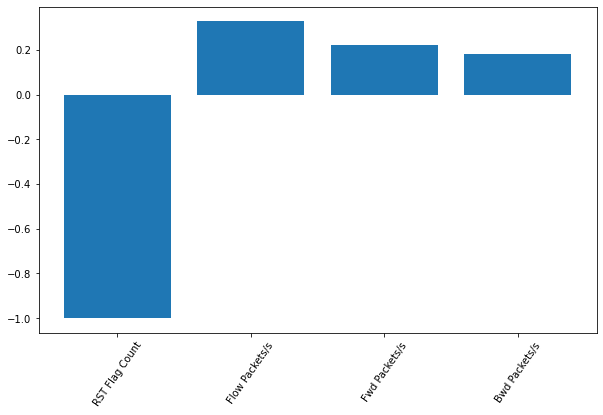

In [87]:
plt.figure(figsize=(10,6))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(rotation = 55) 
plt.xticks(range(len(D)), list(D.keys()))


In [32]:
 # define X_train
X_train = benign_norm.to_numpy() 

In [98]:
X_train.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [99]:
print(len(X_train.columns))
print(len(X_test.columns))

26
26


In [100]:
X_test.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [101]:
# threshold estimation using benign dataset
# predictions for benign dataset
import tensorflow
autoencoder = tensorflow.keras.models.load_model("autoencoder.h5")
x_pred_benign = autoencoder.predict(X_train)
benignMAE = np.mean(np.abs(X_train - x_pred_benign), axis=1)  # raw wise MAE calculation
benign_norm['MAE'] = benignMAE  # add MAE as a column to benignMAE dataframe
threshold = benign_norm['MAE'].quantile(0.99)  # 0.99 quantile threshold
threshold_max = benign_norm['MAE'].max()  # maximum threshold

9506/9506 [==============================] - 9s 903us/step


In [102]:
#%%
# autoencoder prediction results for attack dataset
x_pred_attack = autoencoder.predict(X_test)
attackMAE = np.mean(np.abs(X_test - x_pred_attack), axis=1)  # raw wise MAE calculation
Attack['MAE'] = attackMAE
Attack['pred_label'] = np.where(Attack['MAE']>threshold,1,0)


23658/23658 [==============================] - 29s 1ms/step


In [103]:
print(len(X_train.columns))
print(len(X_test.columns))
X_train = X_train.drop('MAE',1)
print(len(X_train.columns))

27
26
26


In [104]:
# x test with predicted labels
X_test['pred_label'] = Attack['pred_label']

# select only attack data 
X_test_attack = X_test[X_test['pred_label']==1]
print(X_test_attack.shape)
# drop pred_lable column 
X_test_attack_new = X_test_attack.drop(['pred_label'], axis=1, inplace=True)
# print(X_test_attack_new.shape)

(757001, 27)


In [105]:
X_test_attack.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [106]:
X_train=pd.DataFrame(X_train)

In [107]:
len(X_train.columns)

26

In [108]:
len(X_test_attack.columns)

26

In [118]:
exp_model = AnomalyExplanationUsingSHAP(num_anomalies=5)


In [119]:
# model only for attack data 'X_test_attack'

all_sets_explaining_features = exp_model.explain_unsupervised_data(train_data=X_train, 
                                                                   explain_data=X_test_attack,
                                                                   return_shap_values=True)


Training data features: 26
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_20 (Dense)            (None, 10)                270       
                                                                 
 dense_21 (Dense)            (None, 32)                352       
                                                                 
 dense_22 (Dense)            (None, 10)                330       
                                                                 
 dense_23 (Dense)            (None, 32)                352       
                                                                 
 dense_24 (Dense)            (None, 26)                858       
                                                                 
Total params: 2,162
Trainable pa

In [120]:
all_sets_explaining_features

{602902: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.42462947434082154),
  ('Flow Packets/s', 0.0978703506966574)],
 718029: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.41226340884228724),
  ('Flow Packets/s', 0.09596059191280204)],
 384574: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.41204830694881706),
  ('Flow Packets/s', 0.09657459327937001)],
 686625: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.4079170536259522),
  ('Flow Packets/s', 0.09544623583530365)],
 548271: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.39989277328283734),
  ('Flow Packets/s', 0.09638657205231171)]}

In [121]:
def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

In [122]:
D = Convert(all_sets_explaining_features[718029])

In [123]:
D=op

([<matplotlib.axis.XTick at 0x1d441ccaf40>,
 [Text(0, 0, 'RST Flag Count'),
  Text(1, 0, 'Flow Packets/s'),
  Text(2, 0, 'Fwd Packets/s'),
  Text(3, 0, 'Bwd Packets/s')])

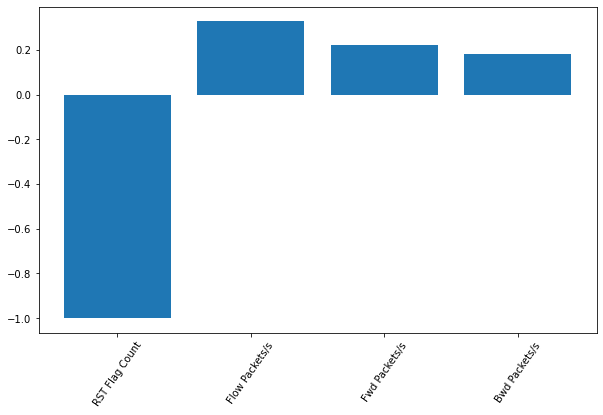

In [124]:
plt.figure(figsize=(10,6))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(rotation = 55) 
plt.xticks(range(len(D)), list(D.keys()))